In [10]:
import numpy as np
import pandas as pd 
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os

In [6]:
# 학습 데이터 준비 
filenames = os.listdir("./train")

categories=[]
for filename in filenames:
    category=filename.split(".")[0]
    if category =="dog":
        categories.append(1)
    else:
        categories.append(0)
df=pd.DataFrame(
    {"filename":filenames,
    "category":categories}
)        
df

,filename,category
0,cat.0.jpg,0
1,cat.1.jpg,0
2,cat.10.jpg,0
3,cat.100.jpg,0
4,cat.1000.jpg,0
...,...,...
24995,dog.9995.jpg,1
24996,dog.9996.jpg,1
24997,dog.9997.jpg,1
24998,dog.9998.jpg,1


In [9]:
FAST_RUN = False
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

<Axes: >

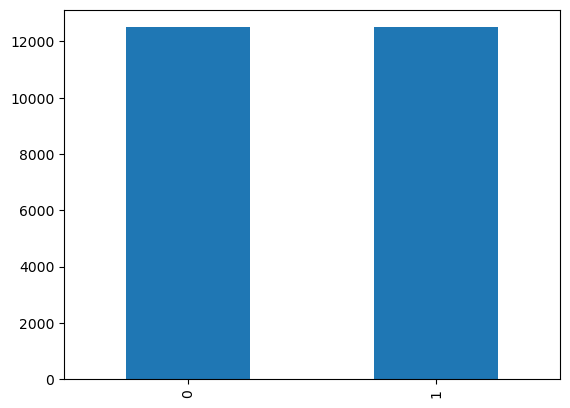

In [8]:
%matplotlib inline
df['category'].value_counts().plot.bar()

### See sample image

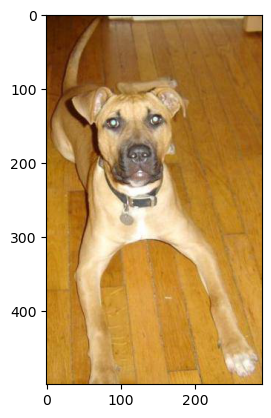

In [14]:
sample = np.random.choice(filenames)
image = load_img("./train/" + sample)
plt.imshow(image)

### model 생성
배치정규화(Batch Normalization): 신경망 입력 데이터를 평균: 0, 분산: 1로 정규화해서 학습이 잘 이루어지도록 하는 방법

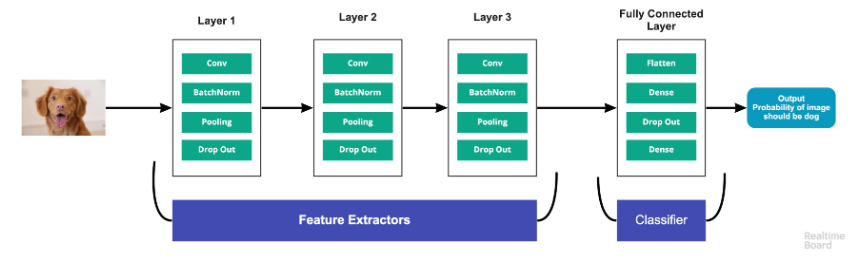
- Input Layer: 입력 이미지 데이터를 나타냅니다. 이미지를 단일 차원 배열로 재구성합니다. 예를 들어 이미지가 64x64 = 4096이면 (4096,1) 배열로 변환
- Conv Layer: 이 레이어는 이미지에서 특징을 추출
- Pooling Layer: 이 레이어는 컨볼루션 후 입력 이미지의 공간적 볼륨을 줄임
- Fully Connected Layer: 네트워크를 한 계층에서 다른 계층으로 연결
- Output Layer: 예측 값 레이어

In [16]:
from keras.models import Sequential
from keras.layers import *

# layer1
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape = (IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

# layer2
model.add(Conv2D(64, (3, 3), activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

# layer 3
model.add(Conv2D(128, (3, 3), activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

# Fully Connected
model.add(Flatten())
model.add(Dense(512, activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(2, activation = 'softmax'))

In [17]:
model.compile(loss="categorical_crossentropy", optimizer="rmsprop", metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 126, 126, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 126, 126, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 63, 63, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 batch_normalization_1 (Bat  (None, 61, 61, 64)       

In [18]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

earlystop = EarlyStopping(patience = 10)


In [19]:
learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_acc',
                                            patience = 2,
                                            verbose = 1,
                                            factor = 0.5,
                                            min_lr = 0.00001)

In [20]:
callbacks = [earlystop, learning_rate_reduction] # 목적: 학습률(learning rate)을 동적으로 조절하여 모델의 훈련을 최적화하는 것이 주요 목적

In [21]:
df["category"] = df["category"].replace({0: 'cat', 1: 'dog'}) 

In [22]:
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

In [26]:
print(train_df['category'].value_counts())
print(validate_df['category'].value_counts())

dog    10015
cat     9985
Name: category, dtype: int64
cat    2515
dog    2485
Name: category, dtype: int64


트레이닝 데이터의 제너레이터 설정 

In [27]:
train_df.shape

(20000, 2)

In [25]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=15

In [36]:
# 트레이닝 데이터의 제너레이터 설정
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale = 1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    "./train/",
    x_col = "filename",
    y_col = "category",
    target_size = IMAGE_SIZE, # (128, 128)
    class_mode = "categorical",
    batch_size = batch_size
)

# 검증이미지니까, 사진 그대로 쓰겠다
validate_datagen = ImageDataGenerator(rescale= 1./255)

validate_generator = train_datagen.flow_from_dataframe(
    validate_df,
    "./train/",
    x_col = "filename",
    y_col = "category",
    target_size = IMAGE_SIZE,
    class_mode = "categorical",
    batch_size = batch_size
)

Found 20000 validated image filenames belonging to 2 classes.
Found 5000 validated image filenames belonging to 2 classes.


### 샘플 데이터 확인

In [37]:
example_df = train_df.sample(n=1).reset_index(drop=True)
example_df

,filename,category
0,cat.238.jpg,cat


In [38]:
example_generator = train_datagen.flow_from_dataframe(
                    example_df,
                    "./train/",
                    x_col = "filename",
                    y_col = "category",
                    target_size = IMAGE_SIZE,
                    class_mode = "categorical")

Found 1 validated image filenames belonging to 1 classes.


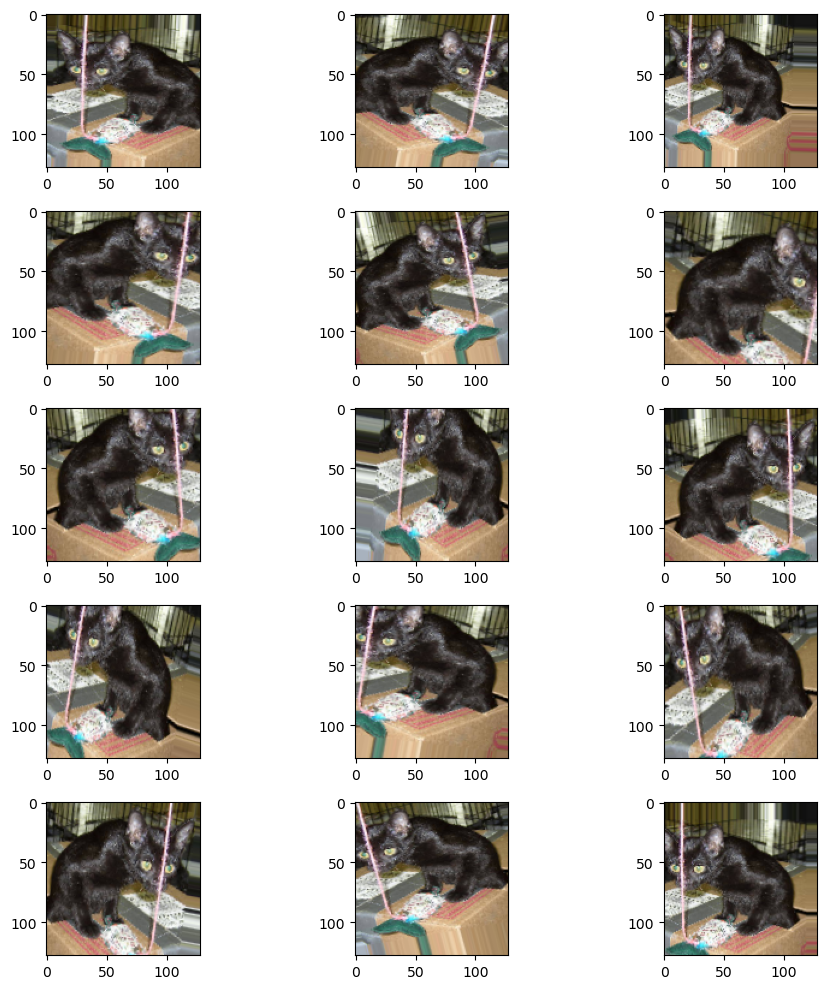

In [39]:
plt.figure(figsize=(10,10))
for i in range(0,15):
    plt.subplot(5,3,i+1)
    for xBatch, yBatch in example_generator:
        image = xBatch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

In [41]:
epochs = 3

history = model.fit_generator( # 제너레이터를 사용하여 데이터를 동적으로 로드하면서 모델을 훈련
    train_generator,
    epochs = epochs,
    steps_per_epoch = total_train//batch_size,
    validation_data = validate_generator,
    validation_steps = total_validate//batch_size,
    callbacks= callbacks,
)

# model 저장
model.save_weights("dog_cat_cnn.h5")

Epoch 1/3


C:\Users\com\AppData\Local\Temp\ipykernel_12376\1204743734.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


1333/1333 [==============================] - 509s 382ms/step - loss: 0.7124 - accuracy: 0.6376 - val_loss: 0.6266 - val_accuracy: 0.6693 - lr: 0.0010
Epoch 2/3
1333/1333 [==============================] - 317s 238ms/step - loss: 0.5584 - accuracy: 0.7214 - val_loss: 0.6589 - val_accuracy: 0.6621 - lr: 0.0010
Epoch 3/3
1333/1333 [==============================] - 319s 239ms/step - loss: 0.5137 - accuracy: 0.7483 - val_loss: 1.0279 - val_accuracy: 0.5596 - lr: 0.0010


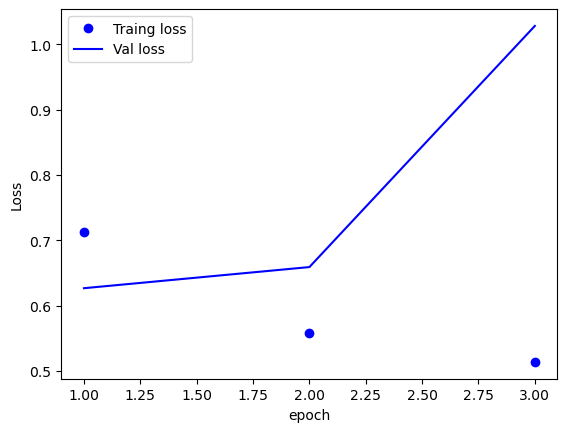

In [42]:
historyDict=history.history

acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

%matplotlib inline
epo = range(1, len(acc)+1)
plt.plot(epo, loss, 'bo', label="Traing loss")
plt.plot(epo, val_loss, 'b', label="Val loss")
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

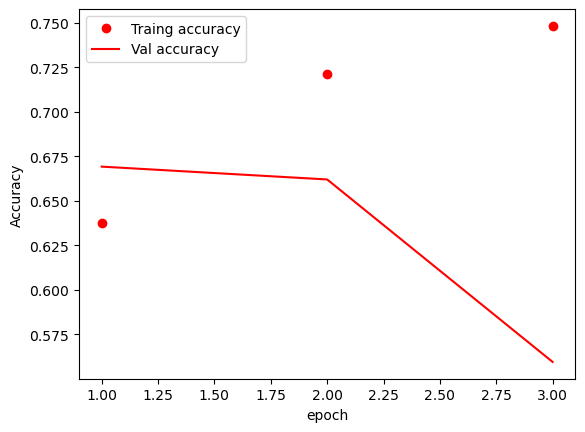

In [43]:
plt.plot(epo, acc, 'ro', label="Traing accuracy")
plt.plot(epo, val_acc, 'r', label="Val accuracy")
plt.xlabel("epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

### 테스트

In [44]:
# 테스트 데이터 준비 
filenames = os.listdir("./test")

test_df=pd.DataFrame( {"filename":filenames} )      
test_df

nbsamples=test_df.shape[0]

In [46]:
test_df

,filename
0,1.jpg
1,10.jpg
2,100.jpg
3,1000.jpg
4,10000.jpg
...,...
12495,9995.jpg
12496,9996.jpg
12497,9997.jpg
12498,9998.jpg


In [45]:
test_datagen=ImageDataGenerator(rescale=1./255)
# 테스트 이미지니까, 사진 그대로 씀
test_generator=test_datagen.flow_from_dataframe(
    test_df,
    "./test/",
    x_col= "filename",
    y_col= None,
    target_size = IMAGE_SIZE,
    class_mode = None,
    batch_size = batch_size,
    shuffle = False)

Found 12500 validated image filenames.


In [47]:
# 예측
predict = model.predict_generator(test_generator,
                                  steps = nbsamples/batch_size,
                                  callbacks=callbacks)
test_df['category'] = np.argmax(predict, axis = 1)


C:\Users\com\AppData\Local\Temp\ipykernel_12376\3637441534.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predict = model.predict_generator(test_generator,


In [48]:
test_df['category'] = test_df['category'].replace({0:'cat', 1: 'dog'})
ex_df = test_df.sample(n=1).reset_index(drop = True)
ex_df

,filename,category
0,12201.jpg,cat


In [49]:
ex_generator = test_datagen.flow_from_dataframe(
                    ex_df,
                    "./test",
                    x_col = "filename",
                    y_col = None,
                    target_size = IMAGE_SIZE,
                    class_mode = None)

Found 1 validated image filenames.


In [50]:
test_sample = list(ex_df.filename)

sample = ""
for test in test_sample:
    sample += test

<function matplotlib.pyplot.show(close=None, block=None)>

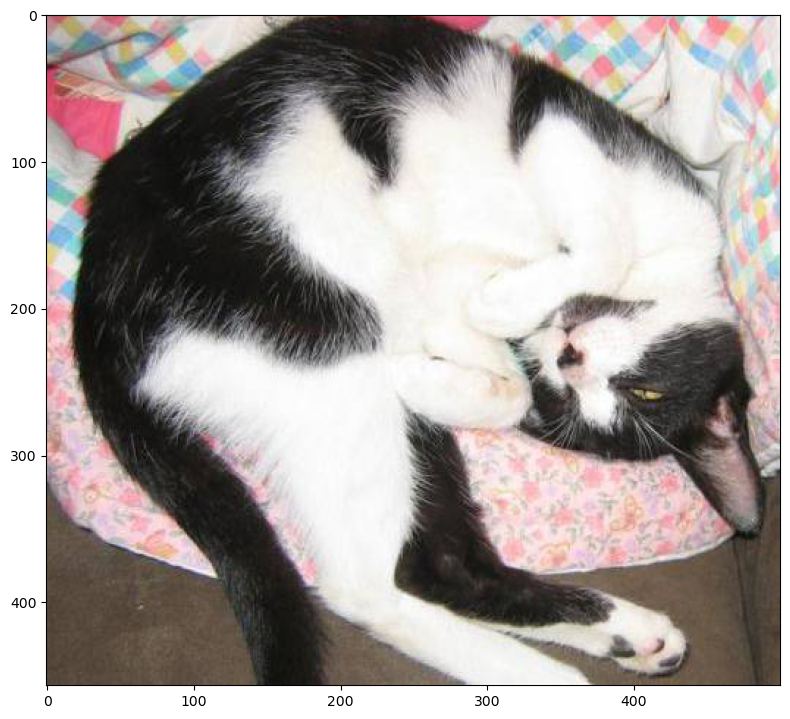

In [51]:
image = load_img('./test/' + sample)
plt.figure(figsize = (8, 8))
plt.imshow(image)

plt.tight_layout()
plt.show